In [1]:
#-----------------------------------------------------------
# Bone Fracture Detection - Improved Model (Version 2)
# ------------------------------------------------------------
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


# -----------------------------
# 1. Dataset Paths
# -----------------------------
train_dir = r"C:\Users\lenovo\Desktop\FractureNet+\Datasets\processed\fracture_detection"

# -----------------------------
# 2. Data Augmentation + Split
# -----------------------------
def preprocess_image(img):
    img = tf.image.per_image_standardization(img)     # normalize contrast & brightness
    img = tf.image.adjust_contrast(img, 2)            # emphasize bone texture
    img = tf.image.adjust_brightness(img, 0.1)
    return img

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4988 images belonging to 2 classes.
Found 1246 images belonging to 2 classes.


In [3]:
# -----------------------------
# 3. Transfer Learning Base
# -----------------------------
base_model = tf.keras.applications.ResNet50(      #use resnet model for better resulit
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True              #After 10 epochs, unfreeze the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False


#base_model.trainable = False  # freeze for initial training

In [4]:
# -----------------------------
# 4. Custom Head with Regularization
# -----------------------------
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

#Allows the model to refine fracture-specific patterns slowly without losing pre-trained knowledge.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 17,212,929 (65.66 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [5]:
from sklearn.utils import class_weight
import numpy as np
# -----------------------------
# 5. Callbacks: Early Stop + Checkpoint
# -----------------------------
os.makedirs("../Models", exist_ok=True)
checkpoint_path = "../Models/best_fracture_model.keras"

early_stop = EarlyStopping(monitor='val_loss', patience=3,
                           restore_best_weights=True)

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy',
                             save_best_only=True)



# Get class indices from your generator
labels = train_gen.classes

# Compute class weights to balance classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dictionary form
class_weights = dict(enumerate(class_weights))

print("✅ Class weights:", class_weights)

# -----------------------------
# 6. Train Model (Initial Phase)
# -----------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)
# -----------------------------
# 7. Fine-Tuning Phase (Corrected)
# -----------------------------

# Unfreeze last 30 layers of the existing base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune for 10 more epochs
history_fine = model.fit(train_gen, validation_data=val_gen, epochs=25, class_weight=class_weights, callbacks=[early_stop, checkpoint])


# -----------------------------
# 8. Evaluate Final Model
# -----------------------------
val_loss, val_acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {val_acc*100:.2f}%")



✅ Class weights: {0: np.float64(1.086710239651416), 1: np.float64(0.9261047159301894)}


C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 807s 5s/step - accuracy: 0.5547 - loss: 0.9719 - val_accuracy: 0.6003 - val_loss: 0.8987
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 805s 5s/step - accuracy: 0.6399 - loss: 0.8771 - val_accuracy: 0.6043 - val_loss: 0.8966
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 901s 6s/step - accuracy: 0.7017 - loss: 0.8145 - val_accuracy: 0.6027 - val_loss: 0.8984
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 931s 6s/step - accuracy: 0.7298 - loss: 0.7724 - val_accuracy: 0.6220 - val_loss: 0.8874
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 714s 5s/step - accuracy: 0.7630 - loss: 0.7321 - val_accuracy: 0.6252 - val_loss: 0.8833
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 580s 4s/step - accuracy: 0.7831 - loss: 0.6965 - val_accuracy: 0.6228 - val_loss: 0.8920
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 1945s 13s/step - accuracy: 0.8035 - loss: 0.6761 - val_accuracy: 0.6220 - val_loss: 0.8913
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.8075 - loss: 0.6555 - val_ac

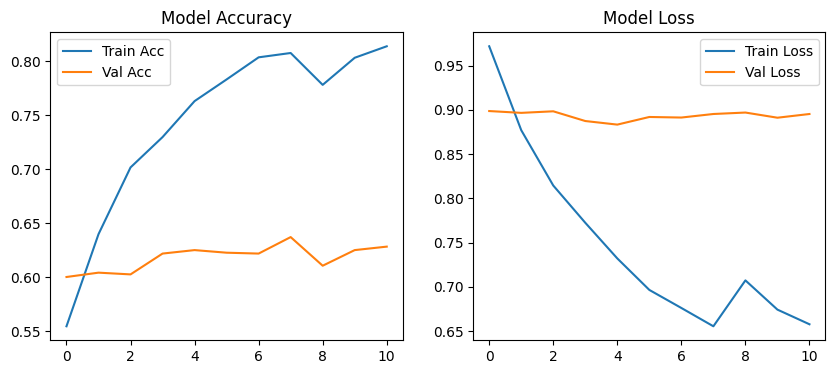


💾 Best model saved as: ../Models/best_fracture_model.keras


In [7]:
# -----------------------------
# 9. Plot Accuracy & Loss
# -----------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

print(f"\n💾 Best model saved as: {checkpoint_path}")